In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 서비스 계정 키 경로 설정
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"/home/eunyu/sprintda05-eunyu-a9946f7dea9c.json"
# GCS의 Parquet 파일 경로
gcs_path = 'gs://final_project_enuyu/data/final_project/votes/accounts_user_contacts.parquet'

# 데이터 불러오기
user_contacts_df = pd.read_parquet(gcs_path, engine='pyarrow')
user_contacts_df

,id,contacts_count,invite_user_id_list,user_id
0,259,30,[],1167696
1,1756,79,[],863169
2,13742,21,[854615],857205
3,13754,29,[],851431
4,13756,28,[849318],855476
...,...,...,...,...
5058,12981327,7,[],1480714
5059,13391623,1,[],1506575
5060,14465598,0,[],1577436
5061,14579987,0,[],1582145


In [4]:
user_contacts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5063 entries, 0 to 5062
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   5063 non-null   int64 
 1   contacts_count       5063 non-null   int64 
 2   invite_user_id_list  5063 non-null   object
 3   user_id              5063 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 158.3+ KB


In [5]:
user_contacts_df.isnull().sum()

id                     0
contacts_count         0
invite_user_id_list    0
user_id                0
dtype: int64

In [7]:
user_contacts_df.describe(include='all')

,id,contacts_count,invite_user_id_list,user_id
count,5.063000e+03,5063.000000,5063,5.063000e+03
unique,NaN,NaN,928,NaN
top,NaN,NaN,[],NaN
freq,NaN,NaN,3905,NaN
mean,2.840907e+06,25.986174,NaN,1.114789e+06
std,2.895428e+06,13.601434,NaN,2.187702e+05
min,2.590000e+02,0.000000,NaN,8.473750e+05
25%,7.475970e+05,16.000000,NaN,8.855155e+05
50%,1.580135e+06,24.000000,NaN,1.119987e+06
75%,4.201598e+06,34.000000,NaN,1.278826e+06


#### 연락처 수

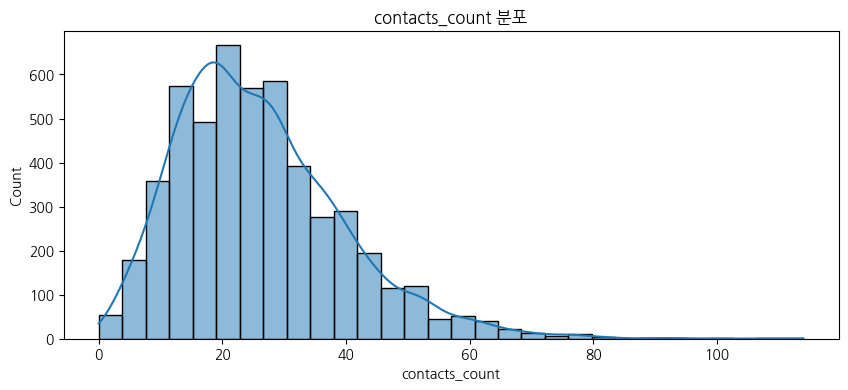

이상치 수: 87


In [8]:
plt.figure(figsize=(10, 4))
sns.histplot(user_contacts_df['contacts_count'], bins=30, kde=True)
plt.title('contacts_count 분포')
plt.show()

# 이상치 확인
q1 = user_contacts_df['contacts_count'].quantile(0.25)
q3 = user_contacts_df['contacts_count'].quantile(0.75)
iqr = q3 - q1
outlier_cond = (user_contacts_df['contacts_count'] < (q1 - 1.5 * iqr)) | (user_contacts_df['contacts_count'] > (q3 + 1.5 * iqr))
print("이상치 수:", outlier_cond.sum())

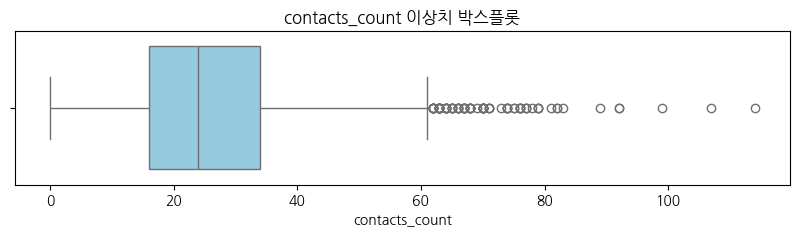

In [11]:

plt.figure(figsize=(10, 2))
sns.boxplot(x=user_contacts_df['contacts_count'], color='skyblue')
plt.title('contacts_count 이상치 박스플롯')
plt.xlabel('contacts_count')
plt.show()


In [12]:
# 이상치 유저 목록
outliers = user_contacts_df[outlier_cond].sort_values(by='contacts_count', ascending=False)
outliers[['user_id', 'contacts_count']].head()

,user_id,contacts_count
35,873573,114
380,877693,107
1152,947480,99
1303,1266116,92
917,875213,92


is_outlier
False    0.317323
True     1.241379
Name: invite_user_count, dtype: float64
is_outlier  invite_user_id_list_empty
False       True                         0.775723
            False                        0.224277
True        True                         0.517241
            False                        0.482759
Name: proportion, dtype: float64


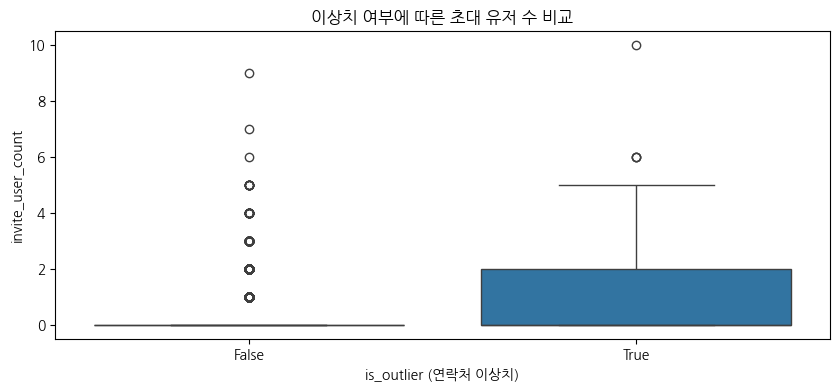

In [13]:
# 이상치 기준 설정
q1 = user_contacts_df['contacts_count'].quantile(0.25)
q3 = user_contacts_df['contacts_count'].quantile(0.75)
iqr = q3 - q1
outlier_cutoff = q3 + 1.5 * iqr

# 이상치 여부 컬럼 생성
user_contacts_df['is_outlier'] = user_contacts_df['contacts_count'] > outlier_cutoff

# 1. 초대한 유저 수 평균 비교
print(user_contacts_df.groupby('is_outlier')['invite_user_count'].mean())

# 2. 초대 여부(빈 리스트 여부) 비율
print(user_contacts_df.groupby('is_outlier')['invite_user_id_list_empty'].value_counts(normalize=True))

# 3. 시각화 비교
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.boxplot(data=user_contacts_df, x='is_outlier', y='invite_user_count')
plt.title('이상치 여부에 따른 초대 유저 수 비교')
plt.xlabel('is_outlier (연락처 이상치)')
plt.ylabel('invite_user_count')
plt.show()

 1. 초대 유저 수 평균 (invite_user_count)
- 일반 유저: 평균 0.32명
- 이상치 유저: 평균 1.24명
                 
이상치 유저는 일반 유저보다 약 4배 더 많은 유저를 초대하고 있음          

2. 초대 여부 (invite_user_id_list_empty)
- 일반 유저 중 초대한 비율: 22.4%
- 이상치 유저 중 초대한 비율: 48.3%
                
이상치 유저는 초대를 한 비율이 2배 이상 높음                                  
→ 초대 기능을 더 자주, 활발히 사용                     

- 일반 유저는 대부분 초대를 거의 안 함
- 이상치 유저는 일부 유저가 5명 이상 초대

#### 초대한 유저 리스트

In [9]:
# 리스트가 빈 값인지 여부
user_contacts_df['invite_user_id_list_empty'] = user_contacts_df['invite_user_id_list'].apply(lambda x: x == '[]')
print(user_contacts_df['invite_user_id_list_empty'].value_counts())

# 리스트 길이(초대한 유저 수 추정)
user_contacts_df['invite_user_count'] = user_contacts_df['invite_user_id_list'].apply(lambda x: 0 if x == '[]' else len(eval(x)))
user_contacts_df['invite_user_count'].describe()


invite_user_id_list_empty
True     3905
False    1158
Name: count, dtype: int64


count    5063.000000
mean        0.333202
std         0.752303
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: invite_user_count, dtype: float64

1. invite_user_id_list_empty
- True (빈 리스트): 3905명 (77.1%)
- False (초대한 적 있음): 1158명 (22.9%)
대부분의 유저가 초대를 하지 않음           
               
2. invite_user_count (초대한 유저 수)
- 평균: 약 0.33명
- 최댓값: 10명
- 75% 지점: 0 → 상위 25%만 초대를 한 경험 있음


#### user_id별 contacts_count 분포

In [10]:
top_users = user_contacts_df.sort_values('contacts_count', ascending=False).head(10)
print(top_users[['user_id', 'contacts_count']])

      user_id  contacts_count
35     873573             114
380    877693             107
1152   947480              99
917    875213              92
1303  1266116              92
1205   948166              89
3630  1303869              83
2781   915445              82
2441  1145662              82
4400  1274312              81
